In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
le = preprocessing.LabelEncoder()
from sklearn.model_selection import train_test_split
import pickle
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


data=pd.read_csv('../../../Sherry-K/data/new_data.csv')

In [31]:
data.head()

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,target,self_pay,medicaid/medicare,coverByInsurance,f_diag,s_diag,t_diag,clustering3,clustering4,clustering2
0,0,220288932,32885451,Caucasian,Male,[50-60),2,6,7,10,...,0,0,0,1,diseases of the circulatory system,neoplasms,neoplasms,0,1,1
1,1,18126858,4788405,Caucasian,Male,[50-60),1,1,7,5,...,0,0,0,0,diseases of the circulatory system,diseases of the circulatory system,diseases of the respiratory system,2,0,0
2,2,21616398,1660293,Caucasian,Female,[60-70),1,1,7,3,...,0,0,0,0,diseases of the digestive system,diseases of the digestive system,"endocrine, nutritional and metabolic diseases,...",2,0,0
3,3,30596088,79713063,Caucasian,Female,[70-80),1,3,7,5,...,0,0,0,0,"endocrine, nutritional and metabolic diseases,...","endocrine, nutritional and metabolic diseases,...",diseases of the genitourinary system,2,0,0
4,4,203180148,103254777,AfricanAmerican,Male,[30-40),1,6,7,10,...,0,0,1,0,diseases of the circulatory system,diseases of the genitourinary system,"endocrine, nutritional and metabolic diseases,...",0,1,1


In [2]:
data.shape

(86500, 55)

In [3]:
X = data.copy()

In [4]:
X = X.drop(['Unnamed: 0','patient_nbr','encounter_id', 'medical_specialty', ], axis = 1)


In [5]:
## removing discharge ids with deceased patients
dead_ids = [11, 13, 14, 19,20,21]
X = X[~X['discharge_disposition_id'].isin(dead_ids)]

In [7]:
X.shape

(84432, 51)

In [12]:
X['target'].value_counts()

0    74817
1     9615
Name: target, dtype: int64

In [25]:
dis_id['ratio 0'] = dis_id['discharge_disposition_id'].map(lambda x: x/74817)
dis_id['ratio 1'] = dis_id['discharge_disposition_id'].map(lambda x: x/9618)
dis_id

discharge_disposition_id   ratio 0   ratio 1
target discharge_disposition_id                                              
0      1                                            46511  0.621664  4.835829
       3                                            10123  0.135303  1.052506
       6                                             9505  0.127043  0.988251
       18                                            2716  0.036302  0.282387
       2                                             1521  0.020330  0.158141
       22                                            1237  0.016534  0.128613
       5                                              797  0.010653  0.082865
       25                                             763  0.010198  0.079330
       4                                              617  0.008247  0.064151
       7                                              454  0.006068  0.047203
       23                                             320  0.004277  0.033271
       8                                               79  0.001056  0.008214
       28                                              70  0.000936  0.007278
       24                                              35  0.000468  0.003639
       15                                              31  0.000414  0.003223
       16                                              10  0.000134  0.001040
       17                                              10  0.000134  0.001040
       9                                                8  0.000107  0.000832
       10                                               5  0.000067  0.000520
       27                                               5  0.000067  0.000520
1      1                                             4768  0.063729  0.495737
       3                                             1750  0.023390  0.181951
       6                                             1376  0.018392  0.143065
       22                                             470  0.006282  0.048867
       18                                             385  0.005146  0.040029
       2                                              294  0.003930  0.030568
       5                                              207  0.002767  0.021522
       4                                               92  0.001230  0.009565
       25                                              80  0.001069  0.008318
       7                                               75  0.001002  0.007798
       28                                              45  0.000601  0.004679
       15                                              24  0.000321  0.002495
       23                                              24  0.000321  0.002495
       8                                               11  0.000147  0.001144
       9                                                6  0.000080  0.000624
       24                                               6  0.000080  0.000624
       12                                               2  0.000027  0.000208

In [21]:
dis_id = pd.DataFrame(X.groupby('target')['discharge_disposition_id'].value_counts())
dis_id

discharge_disposition_id
target discharge_disposition_id                          
0      1                                            46511
       3                                            10123
       6                                             9505
       18                                            2716
       2                                             1521
       22                                            1237
       5                                              797
       25                                             763
       4                                              617
       7                                              454
       23                                             320
       8                                               79
       28                                              70
       24                                              35
       15                                              31
       16                                              10
       17                                              10
       9                                                8
       10                                               5
       27                                               5
1      1                                             4768
       3                                             1750
       6                                             1376
       22                                             470
       18                                             385
       2                                              294
       5                                              207
       4                                               92
       25                                              80
       7                                               75
       28                                              45
       15                                              24
       23                                              24
       8                                               11
       9                                                6
       24                                               6
       12                                               2

In [6]:
for x in list(X.columns):
    print(X.groupby('target')[x].value_counts())

target  race           
0       Caucasian          55849
        AfricanAmerican    14116
        Other               2847
        Hispanic            1527
        Asian                478
1       Caucasian           7302
        AfricanAmerican     1790
        Other                290
        Hispanic             177
        Asian                 56
Name: race, dtype: int64
target  gender         
0       Female             40214
        Male               34600
        Unknown/Invalid        3
1       Female              5202
        Male                4413
Name: gender, dtype: int64
target  age     
0       [70-80)     18878
        [60-70)     16673
        [50-60)     13103
        [80-90)     12171
        [40-50)      7272
        [30-40)      2855
        [90-100)     1973
        [20-30)      1202
        [10-20)       552
        [0-10)        138
1       [70-80)      2604
        [60-70)      2142
        [80-90)      1746
        [50-60)      1409
        [40-50)       86

target  nateglinide
0       No             74302
        Steady           486
        Up                19
        Down              10
1       No              9546
        Steady            67
        Down               1
        Up                 1
Name: nateglinide, dtype: int64
target  chlorpropamide
0       No                74750
        Steady               62
        Up                    4
        Down                  1
1       No                 9611
        Steady                4
Name: chlorpropamide, dtype: int64
target  glimepiride
0       No             70924
        Steady          3516
        Up               237
        Down             140
1       No              9163
        Steady           399
        Up                33
        Down              20
Name: glimepiride, dtype: int64
target  acetohexamide
0       No               74816
        Steady               1
1       No                9615
Name: acetohexamide, dtype: int64
target  glipizide
0       No     

In [327]:
## changing id features from numerical to categorical 

X['admission_type_id'] = pd.Categorical(X.admission_type_id)
X['discharge_disposition_id'] = pd.Categorical(X.discharge_disposition_id)
X['admission_source_id'] = pd.Categorical(X.admission_source_id)


## changing object features to categorical
cat_cols = list(X.select_dtypes(include=[object]).columns)

for col in cat_cols:
    X[col] = pd.Categorical(X[col])


In [328]:
## label encoding all categorical variables to feed into rf

col_to_encode = X[list(X.select_dtypes(include=['category']).columns)]


for col in col_to_encode:
    X[col] = le.fit_transform(X[col])


In [329]:
## creating target variable and dropping from data set

Y = X['target']
X = X.drop('target', axis = 1)

In [330]:
X.shape

(84432, 50)

In [ ]:
precit_proba = model.predict_proba

In [307]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, shuffle = True, stratify = Y, random_state = 0)

### testing for number of estimators

In [74]:
rf=ensemble.RandomForestClassifier()
rf.set_params(oob_score = True, random_state=0, class_weight = 'balanced', n_estimators=50, max_features=45)
rf.fit(X_train, Y_train) # fit 


obb score 0.8844032350851071
train score:  0.9991540049406111
test score:  0.88499802605606
The training error of random forest is: 0.00085
The test error of random forest is: 0.11500


In [ ]:
print("obb score", rf.oob_score_)
print("train score: ", rf.score(X_train, Y_train)) # accuracy
print("test score: ", rf.score(X_test, Y_test)) # accuracy
print("The training error of random forest is: %.5f" %(1 - rf.score(X_train, Y_train)))
print("The test error of random forest is: %.5f" %(1 - rf.score(X_test, Y_test)))

In [118]:
## getting estimate of trees

n_trees_range = range(50, 80, 6)  # OOB score will warning if too few trees
train_error2 = []
test_error2 = []
oob_error = []

for n_trees  in n_trees_range:
    rf.set_params(oob_score = True, random_state=0, class_weight = 'balanced', n_estimators=n_trees, max_features='auto', max_depth = 5)
    rf.fit(X_train, Y_train)
    train_error2.append(1 - rf.score(X_train, Y_train))
    test_error2.append(1 - rf.score(X_test, Y_test))
    oob_error.append(1 - rf.oob_score_)

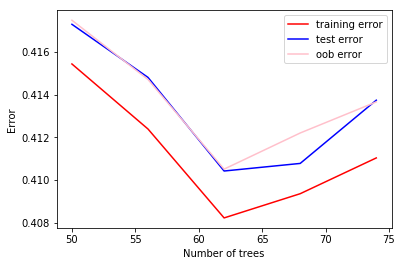

In [119]:
import matplotlib.pyplot as plt
plt.plot(n_trees_range, train_error2, c='red', label='training error')
plt.plot(n_trees_range, test_error2, c='blue', label='test error')
plt.plot(n_trees_range, oob_error, c='pink', label='oob error')
plt.ylabel('Error')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

In [139]:
## getting estimate of depth

depth_range = range(1,8)  # OOB score will warning if too few trees
train_error3 = []
test_error3 = []
oob_error1 = []

for depth  in depth_range:
    rf.set_params(oob_score = True, class_weight = 'balanced', n_estimators=200, max_features='auto', max_depth = depth,min_samples_leaf=4,
            min_samples_split=10)
    rf.fit(X_train, Y_train)
    train_error3.append(1 - rf.score(X_train, Y_train))
    test_error3.append(1 - rf.score(X_test, Y_test))
    oob_error1.append(1 - rf.oob_score_)

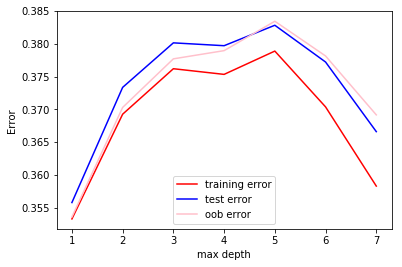

In [140]:
import matplotlib.pyplot as plt
plt.plot(depth_range, train_error3, c='red', label='training error')
plt.plot(depth_range, test_error3, c='blue', label='test error')
plt.plot(depth_range, oob_error1, c='pink', label='oob error')
plt.ylabel('Error')
plt.xlabel('max depth')
plt.legend()
plt.show()

In [272]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=True, random_state=0,
            verbose=0, warm_start=False)>

In [268]:
print(confusion_matrix(Y_test, rf.predict(X_test)))
print("auc for initial model on test set is: ", roc_auc_score(Y_test, rf.predict(X_test)))


auc for initial model on test set is:  0.6167315984808619


In [269]:
print(confusion_matrix(Y_train, rf.predict(X_train)))
print("auc for initial model on train set is: ", roc_auc_score(Y_train, rf.predict(X_train)))

[[33628 18744]
 [ 2432  4298]]
auc for initial model on train set is:  0.6403659090318443


In [310]:
print("auc train score: ", roc_auc_score(Y_train, rf.predict_proba(X_train)[:,1]))
print("auc test score: ",roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]))
print("recall train score: ",recall_score(Y_train, rf.predict(X_train)))
print("recall test score: ",recall_score(Y_test, rf.predict(X_test)))
print("precision train score: ", precision_score(Y_train, rf.predict(X_train)))
print("precision test score: ",precision_score(Y_test, rf.predict(X_test)))
print("accuracy train score: ",accuracy_score(Y_train, rf.predict(X_train)))
print("accuracy test score: ",accuracy_score(Y_test, rf.predict(X_test)))
print(confusion_matrix(Y_test, rf.predict(X_test)))

auc train score:  0.69475833898971
auc test score:  0.65749632550664
recall train score:  0.638632986627043
recall test score:  0.5951473136915078
precision train score:  0.1865289471400052
precision test score:  0.17458057956278597
accuracy train score:  0.6417041724476329
accuracy test score:  0.6333991314646664
[[14327  8118]
 [ 1168  1717]]


### Randomized Search

## setting initial randsearch params

model=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = {0:1,1:9})

n_estimators = [50, 60, 70, 80, 90]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(30, 80, num = 5)]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rand_search_rf = RandomizedSearchCV(model, random_para, cv=5, scoring = 'f1_weighted')

rand_search_rf.fit(X_train, Y_train)

bestparams_rand = rand_search_rf.best_params_
bestparams_score = rand_search_rf.best_score_

bestparams_rand = rand_search_rf.best_params_
rand_search_rf.best_score_

bestparams_rand

### Running Gridsearch

In [141]:


##predict test data
#randomForest.predict(test)
model=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = 'balanced')

###Grid Search
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)
n_estimators = list(range(50, 70, 2))
max_features = ['auto', 'sqrt']
max_depth = list(range(1, 8))
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4, 6,8]
bootstrap = [True]
grid_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search_forest = GridSearchCV(model, grid_para, cv=cv,scoring = "recall", n_jobs = -1)
grid_search_forest.fit(X_train, Y_train)





In [275]:
bestparam= grid_search_forest.best_params_
bestscore= grid_search_forest.best_score_

print(bestparam)
print(bestscore)

{'bootstrap': True, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 54}
0.6279346286418579


In [276]:
model=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = 'balanced', **bestparam)
model.fit(X_train, Y_train)
model.score(X_train, Y_train)

0.5965280362762682

In [274]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=54, n_jobs=None, oob_score=True, random_state=0,
            verbose=0, warm_start=False)>

In [303]:
print("auc train score: ", roc_auc_score(Y_train, model.predict_proba(X_train)[:,1]))
print("auc test score: ",roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))
print("recall train score: ",recall_score(Y_train, model.predict(X_train)))
print("recall test score: ",recall_score(Y_test, model.predict(X_test)))
print("precision train score: ", precision_score(Y_train, model.predict(X_train)))
print("precision test score: ",precision_score(Y_test, model.predict(X_test)))
print("accuracy train score: ",accuracy_score(Y_train, model.predict(X_train)))
print("accuracy test score: ",accuracy_score(Y_test, model.predict(X_test)))
print(confusion_matrix(Y_test, model.predict(X_test)))

auc train score:  0.6531390592548064
auc test score:  0.6453796281532403
recall train score:  0.6270430906389302
recall test score:  0.6149046793760832
precision train score:  0.16512756299890435
precision test score:  0.16206833546501004
accuracy train score:  0.5965280362762682
accuracy test score:  0.5940386893012238
[[13273  9172]
 [ 1111  1774]]


In [312]:
scalerfile = 'best_rf.sav'
pickle.dump(model, open(scalerfile, 'wb'))

In [340]:
roc_auc_score(Y_test, model.predict_proba(X_test)[:,1])

0.6453796281532403

In [355]:
holdout = pd.read_csv('./holdout.csv')


In [356]:
data.head()

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,target,self_pay,medicaid/medicare,coverByInsurance,f_diag,s_diag,t_diag,clustering3,clustering4,clustering2
0,0,220288932,32885451,Caucasian,Male,[50-60),2,6,7,10,...,0,0,0,1,diseases of the circulatory system,neoplasms,neoplasms,0,1,1
1,1,18126858,4788405,Caucasian,Male,[50-60),1,1,7,5,...,0,0,0,0,diseases of the circulatory system,diseases of the circulatory system,diseases of the respiratory system,2,0,0
2,2,21616398,1660293,Caucasian,Female,[60-70),1,1,7,3,...,0,0,0,0,diseases of the digestive system,diseases of the digestive system,"endocrine, nutritional and metabolic diseases,...",2,0,0
3,3,30596088,79713063,Caucasian,Female,[70-80),1,3,7,5,...,0,0,0,0,"endocrine, nutritional and metabolic diseases,...","endocrine, nutritional and metabolic diseases,...",diseases of the genitourinary system,2,0,0
4,4,203180148,103254777,AfricanAmerican,Male,[30-40),1,6,7,10,...,0,0,1,0,diseases of the circulatory system,diseases of the genitourinary system,"endocrine, nutritional and metabolic diseases,...",0,1,1


In [357]:
holdout.head()

,Unnamed: 0,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,self_pay,medicaid/medicare,coverByInsurance,f_diag,s_diag,t_diag,clustering3,clustering4,clustering2,target
0,0,2,0,6,0,0,6,11,22,50,...,0,1,0,13,9,17,2,2,0,0
1,1,2,0,8,0,5,6,2,22,23,...,0,1,0,4,11,4,0,1,0,0
2,2,2,0,6,4,0,13,3,22,24,...,0,0,0,5,11,11,1,0,1,0
3,3,2,0,6,5,2,6,12,18,48,...,0,0,0,4,11,4,2,2,1,1
4,4,2,0,8,1,3,6,5,48,1,...,0,0,0,15,4,15,2,2,1,0


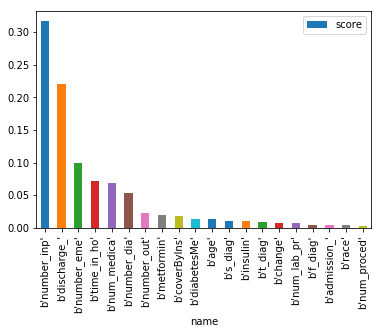

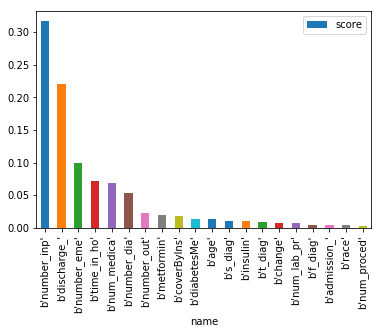

In [341]:
##feature importance
feature_importance = list(zip(X.columns, model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
fea_i=pd.DataFrame({'name':name,'score':score})
fea_i[:20].plot.bar(x='name', y='score')
fea_i

my_fig = fea_i[:20].plot.bar(x='name', y='score')


In [343]:
name

(b'number_inp',
 b'discharge_',
 b'number_eme',
 b'time_in_ho',
 b'num_medica',
 b'number_dia',
 b'number_out',
 b'metformin',
 b'coverByIns',
 b'diabetesMe',
 b'age',
 b's_diag',
 b'insulin',
 b't_diag',
 b'change',
 b'num_lab_pr',
 b'f_diag',
 b'admission_',
 b'race',
 b'num_proced',
 b'A1Cresult',
 b'admission_',
 b'glyburide',
 b'clustering',
 b'gender',
 b'glimepirid',
 b'rosiglitaz',
 b'self_pay',
 b'medicaid/m',
 b'max_glu_se',
 b'glipizide',
 b'clustering',
 b'pioglitazo',
 b'troglitazo',
 b'tolbutamid',
 b'tolazamide',
 b'repaglinid',
 b'nateglinid',
 b'miglitol',
 b'metformin-',
 b'metformin-',
 b'glyburide-',
 b'glipizide-',
 b'glimepirid',
 b'examide',
 b'clustering',
 b'citoglipto',
 b'chlorpropa',
 b'acetohexam',
 b'acarbose')

In [204]:
## adding random feature
X_train['random'] = np.random.randint(0,2, X_train.shape[0])
X_train['random'].value_counts()

0    29604
1    29498
Name: random, dtype: int64

In [264]:
## refitting model with random feature

model=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = 'balanced', **bestparam)
model.fit(X_train, Y_train)
model.score(X_train, Y_train)



0.5965280362762682

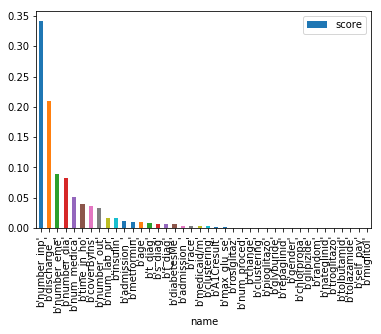

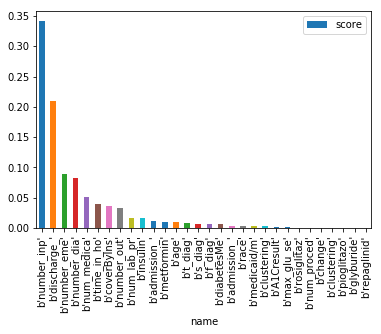

In [206]:
##feature importance
feature_importance = list(zip(X_train.columns, model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
fea_i=pd.DataFrame({'name':name,'score':score})
fea_i[:40].plot.bar(x='name', y='score')
fea_i

my_fig = fea_i[:30].plot.bar(x='name', y='score')

In [187]:
X = X.drop('random', axis = 1)

### Permutated Feature Importance

In [240]:
## running permutated rf for FI

def oob_dropcol_importances(rf, X_train, y_train):
  
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.oob_score = True
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.oob_score = True
        rf_.fit(X_train.drop(col, axis=1), y_train)
        drop_in_score = baseline - rf_.oob_score_
        imp.append(drop_in_score)
    imp = np.array(imp)
    I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    I = I.sort_values('Importance', ascending=False)
    return I

In [241]:
perm_feat_i = oob_dropcol_importances(rf, X_train, Y_train)


In [225]:
pd.DataFrame(feature_sort)

,feature,importance
0,b'number_inp',0.341847
1,b'discharge_',0.208954
2,b'number_eme',0.088964
3,b'number_dia',0.083105
4,b'num_medica',0.050470
5,b'time_in_ho',0.040011
6,b'coverByIns',0.036896
7,b'number_out',0.032971
8,b'num_lab_pr',0.016457
9,b'insulin',0.016150


In [248]:
top_feat = list(perm_feat_i.Feature[:19])

### Re-run model with new FI

In [226]:
X_reduced = X.copy()

In [249]:
### selecting top models above random
X_reduced = X_reduced[top_feat]

In [251]:
X_reduced.shape

(84432, 19)

In [305]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.30, shuffle = True, stratify = Y, random_state = 0)

In [255]:


#randomForest.predict(test)
rf_reduced=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = 'balanced')

###Grid Search
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)
n_estimators = list(range(50, 400, 50))
max_features = ['auto', 'sqrt']
max_depth = list(range(2, 12, 2))
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4, 6,8]
bootstrap = [True]
grid_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search_forest_red = GridSearchCV(rf_reduced, grid_para, cv=cv,scoring = "recall", n_jobs = -1)
grid_search_forest_red.fit(X_train, Y_train)

bestparam_reduced= grid_search_forest.best_params_
bestscore_reduced= grid_search_forest.best_score_

In [256]:
bestparam_reduced= grid_search_forest_red.best_params_
bestscore_reduced= grid_search_forest_red.best_score_
print(bestscore_reduced)
print(bestparam_reduced)

0.5395243612133918
{'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [257]:
rf_reduced.set_params(oob_score = True, random_state=0, class_weight = 'balanced', **bestparam_reduced)
rf_reduced.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [259]:
rf_reduced.score(X_train, Y_train)

0.6267808196000135

In [260]:
confusion_matrix(Y_test, rf_reduced.predict(X_test))

array([[14191,  8254],
       [ 1345,  1540]])

In [261]:
roc_auc_score(Y_test, rf_reduced.predict(X_test))

0.5830260606226736

In [306]:
print("auc train score: ", roc_auc_score(Y_train, rf_reduced.predict_proba(X_train)[:,1]))
print("auc test score: ",roc_auc_score(Y_test, rf_reduced.predict_proba(X_test)[:,1]))
print("recall train score: ",recall_score(Y_train, rf_reduced.predict(X_train)))
print("recall test score: ",recall_score(Y_test, rf_reduced.predict(X_test)))
print("precision train score: ", precision_score(Y_train, rf_reduced.predict(X_train)))
print("precision test score: ",precision_score(Y_test, rf_reduced.predict(X_test)))
print("accuracy train score: ",accuracy_score(Y_train, rf_reduced.predict(X_train)))
print("accuracy test score: ",accuracy_score(Y_test, rf_reduced.predict(X_test)))
print(confusion_matrix(Y_test, rf_reduced.predict(X_test)))

auc train score:  0.6277502091280018
auc test score:  0.6154733021562819
recall train score:  0.5414561664190193
recall test score:  0.5337954939341422
precision train score:  0.1611248673505483
precision test score:  0.15723912599550746
accuracy train score:  0.6267808196000135
accuracy test score:  0.6210422424003158
[[14191  8254]
 [ 1345  1540]]


### Final gridsearch tuning with wider range of params

In [281]:
##predict test data
#randomForest.predict(test)
model_final=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = 'balanced')

###Grid Search
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)
n_estimators = list(range(50, 401, 50))
max_features = ['auto', 'sqrt']
max_depth = list(range(1, 8))
min_samples_split = list(range(2,13,2))
min_samples_leaf = list(range(2,13,2))
bootstrap = [True]
grid_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search_forest_final = GridSearchCV(model, grid_para, cv=cv,scoring = "roc_auc", n_jobs = -1)
grid_search_forest_final.fit(X_train, Y_train)

bestparam_final= grid_search_forest_final.best_params_
bestscore_final= grid_search_forest_final.best_score_

In [284]:
model_final=ensemble.RandomForestClassifier(oob_score = True, random_state=0, class_weight = 'balanced', **bestparam_final)
model_final.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [302]:
print("auc train score: ", roc_auc_score(Y_train, model_final.predict_proba(X_train)[:,1]))
print("auc test score: ",roc_auc_score(Y_test, model_final.predict_proba(X_test)[:,1]))
print("recall train score: ",recall_score(Y_train, model_final.predict(X_train)))
print("recall test score: ",recall_score(Y_test, model_final.predict(X_test)))
print("precision train score: ", precision_score(Y_train, model_final.predict(X_train)))
print("precision test score: ",precision_score(Y_test, model_final.predict(X_test)))
print("accuracy train score: ",accuracy_score(Y_train, model_final.predict(X_train)))
print("accuracy test score: ",accuracy_score(Y_test, model_final.predict(X_test)))
print(confusion_matrix(Y_test, model_final.predict(X_test)))

auc train score:  0.6937205210660642
auc test score:  0.6573181584253902
recall train score:  0.6359583952451708
recall test score:  0.5913344887348354
precision train score:  0.1866387580673295
precision test score:  0.17393964110929852
accuracy train score:  0.6429562451355284
accuracy test score:  0.6335965258586657
[[14343  8102]
 [ 1179  1706]]


In [300]:
roc_auc_score(Y_train, model_final.predict_proba(X_train)[:,1])

0.6937205210660642

### Getting percentiles for high risk patients

In [370]:
X_new = X.copy()
predictions = model.predict_proba(X)[:,1]

In [371]:
X_new["predict_proba"] = predictions
X_new["predict_proba"] = X_new["predict_proba"]
X_new.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,self_pay,medicaid/medicare,coverByInsurance,f_diag,s_diag,t_diag,clustering3,clustering4,clustering2,predict_proba
0,2,1,5,1,5,6,10,45,1,23,...,0,0,1,4,16,16,0,1,1,0.569858
1,2,1,5,0,0,6,5,39,4,17,...,0,0,0,4,4,9,2,0,0,0.454418
2,2,0,6,0,0,6,3,47,0,13,...,0,0,0,5,5,11,2,0,0,0.554489
3,2,0,7,0,2,6,5,61,0,14,...,0,0,0,11,11,6,2,0,0,0.516010
4,0,1,3,0,5,6,10,76,1,23,...,0,1,0,4,6,11,0,1,1,0.528570


In [372]:
X_new['target'] = Y


In [373]:
X_new.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,medicaid/medicare,coverByInsurance,f_diag,s_diag,t_diag,clustering3,clustering4,clustering2,predict_proba,target
0,2,1,5,1,5,6,10,45,1,23,...,0,1,4,16,16,0,1,1,0.569858,0
1,2,1,5,0,0,6,5,39,4,17,...,0,0,4,4,9,2,0,0,0.454418,0
2,2,0,6,0,0,6,3,47,0,13,...,0,0,5,5,11,2,0,0,0.554489,0
3,2,0,7,0,2,6,5,61,0,14,...,0,0,11,11,6,2,0,0,0.516010,0
4,0,1,3,0,5,6,10,76,1,23,...,1,0,4,6,11,0,1,1,0.528570,0


### Running model on hold out

In [ ]:
holdout
holdout = holdout.drop(['Unnamed: 0', 'medical_specialty', ], axis = 1)
dead_ids = [11, 13, 14, 19,20,21]
holdout = holdout[~holdout['discharge_disposition_id'].isin(dead_ids)]
holdout['admission_type_id'] = pd.Categorical(holdout.admission_type_id)
holdout['discharge_disposition_id'] = pd.Categorical(holdout.discharge_disposition_id)
holdout['admission_source_id'] = pd.Categorical(holdout.admission_source_id)


## changing object features to categorical
cat_cols = list(holdout.select_dtypes(include=[object]).columns)

for col in cat_cols:
    X[col] = pd.Categorical(holdout[col])
    
col_to_encode = holdout[list(holdout.select_dtypes(include=['category']).columns)]


for col in col_to_encode:
    holdout[col] = le.fit_transform(holdout[col])
    

Y_hold = holdout['target']
X_hold = holdout.drop('target', axis = 1)

In [362]:
print("auc holdout score: ", roc_auc_score(Y_hold, model.predict_proba(X_hold)[:,1]))
print("recall holdout score: ",recall_score(Y_hold, model.predict(X_hold)))
print("precision holdout score: ", precision_score(Y_hold, model.predict(X_hold)))
print("accuracy holdout score: ",accuracy_score(Y_hold, model.predict(X_hold)))
print(confusion_matrix(Y_hold, model.predict(X_hold)))

auc holdout score:  0.648875152764496
recall holdout score:  0.615623062616243
precision holdout score:  0.15749405233941316
accuracy holdout score:  0.6002964759787076
[[7916 5312]
 [ 620  993]]


In [363]:
X_new.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,medicaid/medicare,coverByInsurance,f_diag,s_diag,t_diag,clustering3,clustering4,clustering2,predict_proba,target
0,2,1,5,1,5,6,10,45,1,23,...,0,1,4,16,16,0,1,1,56,0
1,2,1,5,0,0,6,5,39,4,17,...,0,0,4,4,9,2,0,0,45,0
2,2,0,6,0,0,6,3,47,0,13,...,0,0,5,5,11,2,0,0,55,0
3,2,0,7,0,2,6,5,61,0,14,...,0,0,11,11,6,2,0,0,51,0
4,0,1,3,0,5,6,10,76,1,23,...,1,0,4,6,11,0,1,1,52,0


In [365]:
dsa = pd.qcut(model.predict_proba(X)[:,1],q=100)
print(list(dsa.categories))

[Interval(0.356, 0.399, closed='right'), Interval(0.399, 0.406, closed='right'), Interval(0.406, 0.41, closed='right'), Interval(0.41, 0.413, closed='right'), Interval(0.413, 0.416, closed='right'), Interval(0.416, 0.418, closed='right'), Interval(0.418, 0.42, closed='right'), Interval(0.42, 0.422, closed='right'), Interval(0.422, 0.424, closed='right'), Interval(0.424, 0.425, closed='right'), Interval(0.425, 0.427, closed='right'), Interval(0.427, 0.429, closed='right'), Interval(0.429, 0.43, closed='right'), Interval(0.43, 0.432, closed='right'), Interval(0.432, 0.433, closed='right'), Interval(0.433, 0.434, closed='right'), Interval(0.434, 0.436, closed='right'), Interval(0.436, 0.437, closed='right'), Interval(0.437, 0.438, closed='right'), Interval(0.438, 0.44, closed='right'), Interval(0.44, 0.441, closed='right'), Interval(0.441, 0.442, closed='right'), Interval(0.442, 0.444, closed='right'), Interval(0.444, 0.445, closed='right'), Interval(0.445, 0.447, closed='right'), Interva

In [367]:
quant = pd.DataFrame(columns =["percentile", "min", "max"])
for i in range(100):
    print([i,dsa.categories[i].left,dsa.categories[i].right])
    quant.append({"percentile":i ,"min":dsa.categories[i].left, "max":dsa.categories[i].right}, ignore_index=True)



[0, 0.356, 0.399]
[1, 0.399, 0.406]
[2, 0.406, 0.41]
[3, 0.41, 0.413]
[4, 0.413, 0.416]
[5, 0.416, 0.418]
[6, 0.418, 0.42]
[7, 0.42, 0.422]
[8, 0.422, 0.424]
[9, 0.424, 0.425]
[10, 0.425, 0.427]
[11, 0.427, 0.429]
[12, 0.429, 0.43]
[13, 0.43, 0.432]
[14, 0.432, 0.433]
[15, 0.433, 0.434]
[16, 0.434, 0.436]
[17, 0.436, 0.437]
[18, 0.437, 0.438]
[19, 0.438, 0.44]
[20, 0.44, 0.441]
[21, 0.441, 0.442]
[22, 0.442, 0.444]
[23, 0.444, 0.445]
[24, 0.445, 0.447]
[25, 0.447, 0.448]
[26, 0.448, 0.449]
[27, 0.449, 0.451]
[28, 0.451, 0.452]
[29, 0.452, 0.453]
[30, 0.453, 0.455]
[31, 0.455, 0.456]
[32, 0.456, 0.458]
[33, 0.458, 0.459]
[34, 0.459, 0.461]
[35, 0.461, 0.462]
[36, 0.462, 0.463]
[37, 0.463, 0.465]
[38, 0.465, 0.466]
[39, 0.466, 0.468]
[40, 0.468, 0.469]
[41, 0.469, 0.471]
[42, 0.471, 0.472]
[43, 0.472, 0.474]
[44, 0.474, 0.476]
[45, 0.476, 0.478]
[46, 0.478, 0.48]
[47, 0.48, 0.482]
[48, 0.482, 0.484]
[49, 0.484, 0.486]
[50, 0.486, 0.488]
[51, 0.488, 0.49]
[52, 0.49, 0.493]
[53, 0.493, 0.4

In [384]:
X_new['target'][X_new['predict_proba']> .609].value_counts()

0    539
1    293
Name: target, dtype: int64

In [ ]:
df1 = df[(df.a != -1) & (df.b != -1)]


In [382]:
X_new['target'][(X_new['predict_proba']> .596) & (X_new['predict_proba']<.609)].value_counts()

0    614
1    241
Name: target, dtype: int64

In [385]:
percentiles = [(0.609, 0.66), (0.596, 0.609),(0.589, 0.596),
               (0.585, 0.589),(0.58, 0.585),(0.576, 0.58),
               (0.57, 0.576),(0.562, 0.57),(0.556, 0.562),(0.552, 0.556)]


In [387]:
for x in percentiles:
    print(x[0],x[1])

0.609 0.66
0.596 0.609
0.589 0.596
0.585 0.589
0.58 0.585
0.576 0.58
0.57 0.576
0.562 0.57
0.556 0.562
0.552 0.556


In [389]:
for x in percentiles:
    print(X_new['target'][(X_new['predict_proba']>x[0]) & (X_new['predict_proba']<x[1])].value_counts()[1]/844)

0.3471563981042654
0.28554502369668244
0.2559241706161137
0.2132701421800948
0.2523696682464455
0.1646919431279621
0.20971563981042654
0.2334123222748815
0.21800947867298578
0.1646919431279621


In [391]:
data=pd.read_csv('../../../Sherry-K/data/diabetic_data.csv')

In [392]:
data.shape

(101766, 50)